In [ ]:
# Step 1: Upload your zip file (ravdess_data.zip)
#from google.colab import files
#uploaded = files.upload()

# Step 2: Unzip with the exact uploaded file name
!unzip -q ravdess_data.zip -d ./ravdess

# Step 3: Check all wav files found recursively
import glob
file_list = glob.glob('./ravdess/**/*.wav', recursive=True)
print(f"Total audio files found: {len(file_list)}")
print("First 5 files:", file_list[:5])


Total audio files found: 1012
First 5 files: ['./ravdess/ravdess_data/Audio_Song_Actors_01-24/Actor_12/03-02-05-01-02-02-12.wav', './ravdess/ravdess_data/Audio_Song_Actors_01-24/Actor_12/03-02-06-01-01-02-12.wav', './ravdess/ravdess_data/Audio_Song_Actors_01-24/Actor_12/03-02-02-01-02-02-12.wav', './ravdess/ravdess_data/Audio_Song_Actors_01-24/Actor_12/03-02-02-02-02-02-12.wav', './ravdess/ravdess_data/Audio_Song_Actors_01-24/Actor_12/03-02-02-01-01-01-12.wav']


In [ ]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install json-tricks

In [ ]:
%%capture
!pip install tensorflow

In [ ]:
%%capture
import numpy as np
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn

In [ ]:
# Emotion kind validation function for TESS database, due to emotions written within the file names.
def find_emotion_T(name):
        if('neutral' in name): return "01"
        elif('happy' in name): return "03"
        elif('sad' in name): return "04"
        elif('angry' in name): return "05"
        elif('fear' in name): return "06"
        elif('disgust' in name): return "07"
        elif('ps' in name): return "08"
        else: return "-1"


# 'emotions' list fix for classification purposes:
#     Classification values start from 0, Thus an 'n = n-1' operation has been executed for both RAVDESS and TESS databases:
def emotionfix(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # calm
    elif e_num == "03": return 2 # happy
    elif e_num == "04": return 3 # sad
    elif e_num == "05": return 4 # angry
    elif e_num == "06": return 5 # fear
    elif e_num == "07": return 6 # disgust
    else:
        return 7 # suprised

In [ ]:
# Maximum samples count for padding purposes.

sample_lengths = []
folder_path = '/content/ravdess'

for subdir, dirs, files in os.walk(folder_path):
  for file in files:
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    xt, index = librosa.effects.trim(x, top_db=30)

    sample_lengths.append(len(xt))

print('Maximum sample length:', np.max(sample_lengths))

Maximum sample length: 243200


In [ ]:
import time
import numpy as np
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn

tic = time.perf_counter()

# Initialize data lists
rms = []
zcr = []
mfcc = []
emotions = []

# Initialize variables
total_length = 243200 # desired frame length for all of the audio samples.
frame_length = 2048
hop_length = 512

folder_path = '/content/ravdess'

for subdir, dirs, files in os.walk(folder_path):
  for file in files:

    # Fetch the sample rate.
      _, sr = librosa.load(path = os.path.join(subdir,file), sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
    # Load the audio file.
      rawsound = AudioSegment.from_file(os.path.join(subdir,file))
    # Normalize the audio to +5.0 dBFS.
      normalizedsound = effects.normalize(rawsound, headroom = 0)
    # Transform the normalized audio to np.array of samples.
      normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Trim silence from the beginning and the end.
      xt, index = librosa.effects.trim(normal_x, top_db=30)
      #print(file,"\t", len(xt), "\t", rawsound.dBFS, "\t", normalizedsound.dBFS) #--QA purposes if needed--
    # Pad for duration equalization.
    # Check if the length after trimming is greater than the total_length
      padding_length = total_length - len(xt)
      if padding_length < 0:
          # If the trimmed length is longer, pad with 0
          padded_x = xt
      else:
          # Otherwise, pad as before
          padded_x = np.pad(xt, (0, padding_length), 'constant')

    # Noise reduction.
      final_x = nr.reduce_noise(padded_x, sr=sr) #updated 03/03/22

   # Features extraction
      # Corrected: Explicitly pass 'final_x' as the 'y' argument
      f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
      f2 = librosa.feature.zero_crossing_rate(y=final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR
      f3 = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC

   # Emotion extraction from the different databases
      if (find_emotion_T(file) != "-1"): #TESS database validation
            name = find_emotion_T(file)
      else:                              #RAVDESS database validation
            name = file[6:8]

   # Filling the data lists
      rms.append(f1)
      zcr.append(f2)
      mfcc.append(f3)
      emotions.append(emotionfix(name))

toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

Running time: 3.6100 minutes


In [ ]:
# Adjusting features shape to the 3D format: (batch, timesteps, feature)

# Calculate the target number of frames based on total_length and hop_length
# Using ceil to ensure we capture all potential frames
target_frames_rms_zcr = int(np.ceil(total_length / hop_length))
target_frames_mfcc = int(np.ceil(total_length / hop_length)) # MFCCs also depend on hop_length

processed_rms = []
processed_zcr = []
processed_mfcc = []

for r, z, m in zip(rms, zcr, mfcc):
    # Pad or truncate RMS to target_frames_rms_zcr
    if r.shape[1] < target_frames_rms_zcr:
        r_padded = np.pad(r, ((0, 0), (0, target_frames_rms_zcr - r.shape[1])), 'constant')
    else:
        r_padded = r[:, :target_frames_rms_zcr]
    processed_rms.append(r_padded)

    # Pad or truncate ZCR to target_frames_rms_zcr
    if z.shape[1] < target_frames_rms_zcr:
        z_padded = np.pad(z, ((0, 0), (0, target_frames_rms_zcr - z.shape[1])), 'constant')
    else:
        z_padded = z[:, :target_frames_rms_zcr]
    processed_zcr.append(z_padded)

    # Pad or truncate MFCC to target_frames_mfcc
    if m.shape[1] < target_frames_mfcc:
        m_padded = np.pad(m, ((0, 0), (0, target_frames_mfcc - m.shape[1])), 'constant')
    else:
        m_padded = m[:, :target_frames_mfcc]
    processed_mfcc.append(m_padded)


f_rms = np.asarray(processed_rms).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(processed_zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(processed_mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

ZCR shape: (1012, 475, 1)
RMS shape: (1012, 475, 1)
MFCCs shape: (1012, 475, 13)


In [ ]:
# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save X,Y arrays as lists to json files.

x_data = X.tolist()
x_path = '/content/drive/My Drive/Colab Notebooks/X_datanew.json' # FILE SAVE PATH
dump(obj = x_data, fp = x_path)

y_data = Y.tolist()
y_path = '/content/drive/My Drive/Colab Notebooks/Y_datanew.json' # FILE SAVE PATH
dump(obj = y_data, fp = y_path)

'[[4], [5], [1], [1], [1], [2], [2], [1], [1], [2], [2], [0], [2], [3], [0], [5], [4], [5], [4], [5], [5], [4], [2], [3], [3], [0], [4], [3], [4], [3], [5], [1], [4], [3], [3], [5], [5], [1], [4], [2], [2], [1], [3], [0], [0], [2], [2], [1], [2], [0], [5], [0], [5], [4], [2], [1], [1], [5], [4], [4], [4], [5], [1], [5], [1], [5], [1], [3], [4], [1], [5], [2], [1], [4], [3], [5], [3], [3], [4], [3], [4], [2], [2], [3], [0], [3], [3], [2], [5], [3], [5], [4], [4], [0], [5], [3], [3], [5], [1], [3], [1], [1], [2], [2], [3], [0], [4], [2], [4], [1], [5], [4], [4], [2], [1], [5], [5], [1], [3], [2], [1], [2], [5], [4], [3], [2], [3], [4], [0], [0], [2], [1], [4], [5], [0], [4], [5], [2], [0], [4], [3], [2], [3], [1], [1], [4], [0], [3], [2], [1], [3], [5], [4], [5], [1], [3], [5], [4], [2], [5], [2], [3], [2], [1], [5], [5], [3], [4], [1], [2], [2], [1], [1], [3], [0], [4], [3], [4], [0], [1], [3], [1], [5], [1], [4], [5], [5], [1], [5], [5], [0], [5], [3], [1], [2], [4], [3], [0], [4], [1]

In [ ]:
# Load X,Y json files back into lists, convert to np.arrays

x_path = '/content/drive/My Drive/Colab Notebooks/X_datanew.json' # FILE LOAD PATH
X = load(x_path)
X = np.asarray(X, dtype = 'float32')

y_path = '/content/drive/My Drive/Colab Notebooks/Y_datanew.json' # FILE LOAD PATH
Y = load(y_path)
Y = np.asarray(Y, dtype = 'int8')

In [ ]:
# Split to train, validation, and test sets.
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

#'One-hot' vectors for Y: emotion classification
# Remove the dtype argument and flatten the input arrays to 1D
y_train_class = tf.keras.utils.to_categorical(y_train.flatten(), 8)
y_val_class = tf.keras.utils.to_categorical(y_val.flatten(), 8)

In [ ]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(885, 475, 15)
(88, 475, 15)
(39, 475, 15)


In [ ]:
# Save x_test, y_test to JSON.

file_path = 'x_test_data.json'
dump(obj = x_test, fp = file_path)

file_path = 'y_test_data.json'
dump(obj = y_test, fp = file_path)

'{"__ndarray__": [[4], [5], [1], [2], [3], [5], [3], [1], [5], [5], [5], [3], [3], [3], [5], [1], [3], [0], [5], [3], [2], [4], [4], [3], [3], [2], [1], [3], [2], [5], [1], [3], [3], [5], [1], [2], [2], [5], [4]], "dtype": "int8", "shape": [39, 1], "Corder": true}'

In [ ]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks

In [ ]:
# Initializing the model

model = Sequential()
model.add(layers.LSTM(64, return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(8, activation = 'softmax'))
print(model.summary())

batch_size = 23

# Callbacks functions
# Change the file extension to .keras
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/best_weights.keras'

#-> Save the best weights
# No changes needed here, as save_best_only=True saves the entire model which now requires .keras
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy',
                                    factor=0.1, patience=100)

# Compile & train
model.compile(loss='categorical_crossentropy',
                optimizer='RMSProp',
                metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class,
                      epochs=340, batch_size = batch_size,
                      validation_data = (x_val, y_val_class),
                      callbacks = [mcp_save, rlrop])
# Define the best weights to the model.
# Ensure to load the weights from the updated .keras file
model.load_weights(checkpoint_path)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 475, 64)        │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,024 (211.03 KB)

 Trainable params: 54,024 (211.03 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/340
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 312ms/step - categorical_accuracy: 0.1981 - loss: 1.9230 - val_categorical_accuracy: 0.2614 - val_loss: 1.6432 - learning_rate: 0.0010
Epoch 2/340
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 289ms/step - categorical_accuracy: 0.2527 - loss: 1.6718 - val_categorical_accuracy: 0.2500 - val_loss: 1.6982 - learning_rate: 0.0010
Epoch 3/340
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 301ms/step - categorical_accuracy: 0.3011 - loss: 1.6226 - val_categorical_accuracy: 0.3409 - val_loss: 1.6125 - learning_rate: 0.0010
Epoch 4/340
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 282ms/step - categorical_accuracy: 0.2994 - loss: 1.6247 - val_categorical_accuracy: 0.2841 - val_loss: 1.6234 - learning_rate: 0.0010
Epoch 5/340
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 294ms/step - categorical_accuracy: 0.3386 - loss: 1.5953 - val_categorical_accuracy: 0.3182 - val_loss: 1.5779 - learning_rate: 0.0010
Epoch 6/340
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 290ms/step - categorical_accuracy: 0.3254 - loss: 1.5873 - val

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

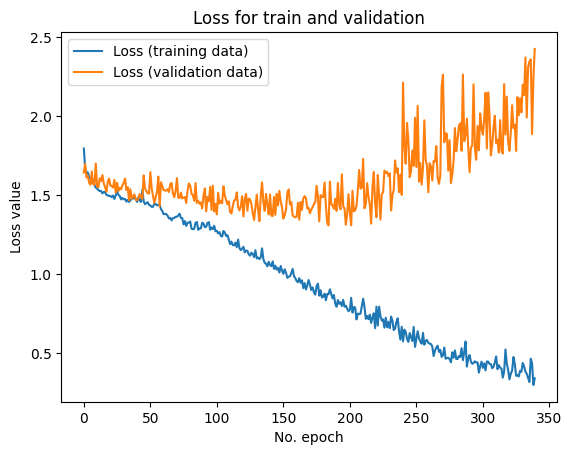

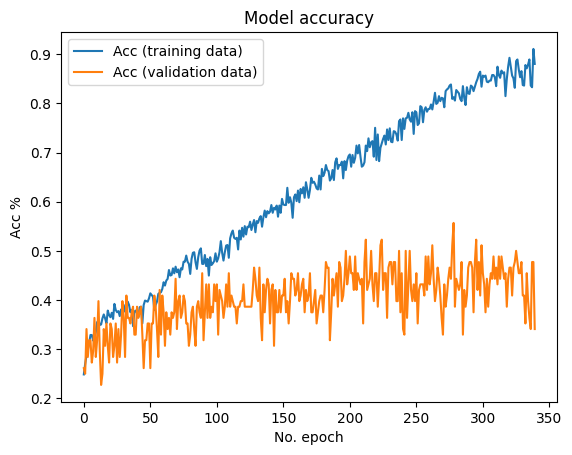

In [ ]:
# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Validation score
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)

3/3 - 0s - 86ms/step - categorical_accuracy: 0.5568 - loss: 1.7163


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Text(0.5, 58.7222222222222, 'Predicted emotion')

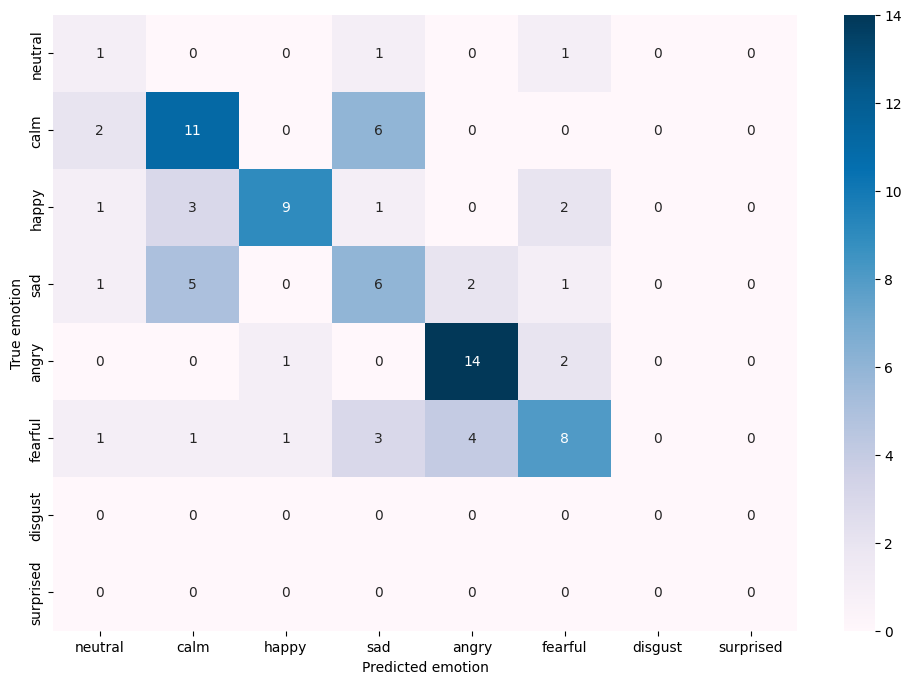

In [ ]:
# Validation Confusion matrix
import pandas as pd
import numpy as np # Ensure numpy is imported
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Recreate the one-hot encoded y_val_class just for this cell
# assuming y_val still holds the original integer labels
y_val_class_onehot = tf.keras.utils.to_categorical(y_val.flatten(), 8)

# Now use the original integer labels for the true values in confusion matrix
y_val_true_labels = y_val.flatten() # Use the original flattened integer labels

predictions = model.predict(x_val)
y_pred_class = np.argmax(predictions, axis=1)

# Use the true integer labels and the predicted integer labels for confusion matrix
# Specify all possible labels (0 to 7) to ensure the matrix is 8x8
cm = confusion_matrix(y_val_true_labels, y_pred_class, labels=list(range(8)))

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [ ]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
neutral : 0.3333
calm : 0.5789
happy : 0.5625
sad : 0.4000
angry : 0.8235
fearful : 0.4444
disgust : nan
surprised : nan


<ipython-input-38-42ae9e950c21>:5: RuntimeWarning: invalid value encountered in divide
  acc = values / row_sum


In [ ]:
# Saving model & weights

from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
saved_model_path = '/content/drive/My Drive/Colab Notebooks/model8723.json'
# Change the weights file path extension to .weights.h5
saved_weights_path = '/content/drive/My Drive/Colab Notebooks/model8723.weights.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)

model.save_weights(saved_weights_path)
print("Saved model to disk")

Saved model to disk


In [ ]:
!pip install pydot

In [ ]:
# Reading the model from JSON file

saved_model_path = '/content/drive/My Drive/Colab Notebooks/model8723.json'
# Corrected the weights file path to match the saving cell
saved_weights_path = '/content/drive/My Drive/Colab Notebooks/model8723.weights.h5'

with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()

# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path) # Now this path should be correct

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy',
                optimizer='RMSProp',
                metrics=['categorical_accuracy'])

# Model's structure visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [ ]:
# Loading x_test, y_test json files, and converting to np.arrays

x_test = load( 'x_test_data.json')
x_test = np.asarray(x_test).astype('float32')

y_test = load('y_test_data.json')
y_test = np.asarray(y_test).astype('int8')

# Remove the dtype argument from to_categorical
# Also, flatten y_test as to_categorical expects a 1D array
y_test_class = tf.keras.utils.to_categorical(y_test.flatten(), 8)

In [ ]:
loss, acc = model.evaluate(x_test, y_test_class, verbose=2)

2/2 - 1s - 396ms/step - categorical_accuracy: 0.5641 - loss: 1.2585


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step 


Text(0.5, 58.7222222222222, 'Predicted emotion')

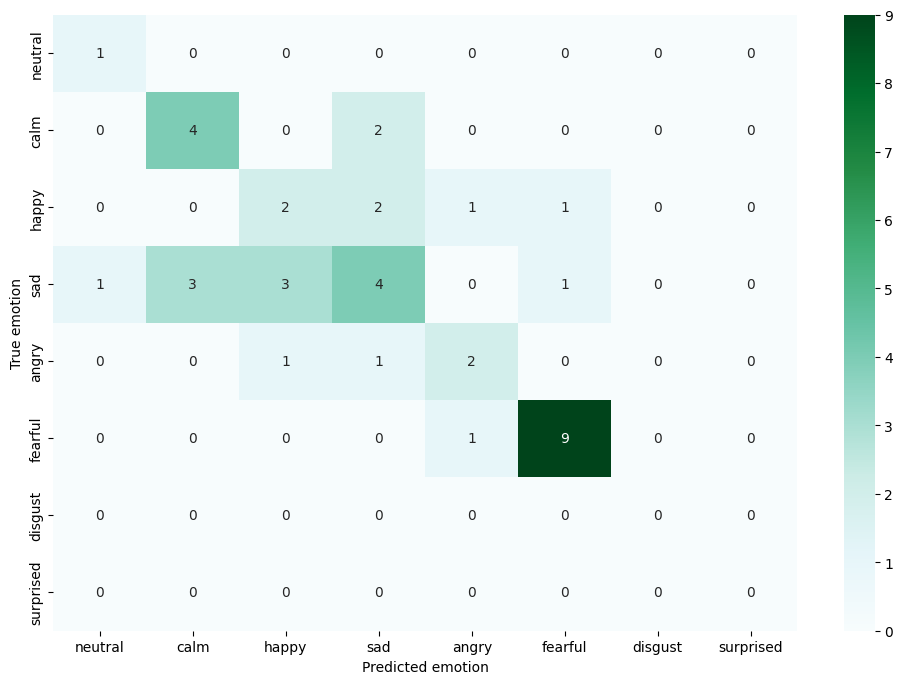

In [ ]:
# Test set Confusion matrix

# y_test_class was already converted to integer labels in the previous cell,
# but if it wasn't, you would do it here:
# y_test_class = np.argmax(y_test_class, axis=1) # Ensure y_test_class contains integer labels

predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

# Specify all possible labels (0 to 7) to ensure the matrix is 8x8
cm=confusion_matrix(y_test_class, y_pred_class, labels=list(range(8)))

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [ ]:
# Test set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Test set predicted emotions accuracy:
neutral : 1.0000
calm : 0.6667
happy : 0.3333
sad : 0.3333
angry : 0.5000
fearful : 0.9000
disgust : nan
surprised : nan


<ipython-input-53-224953d10b6d>:5: RuntimeWarning: invalid value encountered in divide
  acc = values / row_sum
